## COMP5625M Practical Assessment - Deep Learning [100 Marks]


<div class="logos"><img src="Comp5625M_logo.jpg" width="220px" align="right"></div>

This assessment is divided into two parts:
> 1. Image classification using DNN and CNN [70 Marks]
> 2. Use of RNN to predict texts for image captioning [30 Marks]

The maximum number of marks for each part is shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 50% of the final grade for the module.


### Motivation

Through this coursework, you will:

> 1. Understand and implement your first deep neural network and convolutional neural network (CNN) and see how these can be used for classification problem
> 2. Practice building, evaluating, and finetuning your CNN on an image dataset from development to testing stage.
> 3. You will learn to tackle overfitting problem using strategies such as data augmentation and drop out.
> 4. Compare your model performance and accuracy with others, such as the leaderboard on Kaggle
> 5. Use RNNs to predict the caption of an image from established word vocabularies
> 6. Understand and visualise text predictions for a given image.


### Setup and resources

You must work using this provided template notebook.

Having a GPU will speed up the training process. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.


Your student username (for example, ```sc15jb```):

mm23rn

Your full name:

Rajarshi Nandi

### Part I: Image Classification [70 marks]

#### Dataset
This coursework will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Direct access of data is possible by clicking here, please use your university email to access this](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/ESF87mN6kelIkjdISkaRow8BublW27jB-P8eWV6Rr4rxtw?e=SPASDB)

>[To submit your results on the Kaggle competition. You can also access data here](https://www.kaggle.com/t/9105198471a3490d9057026d27d8a711)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb`` (see the ``note`` below)

``Note:`` If the name is already taken in the Kaggle then please use a similar pseudo name and add a note in your submission with the name you have used in the Kaggle.

#### Submitting your test result to Kaggle leaderboard
The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard. More information is provided in the related section below.


## Required packages

[1] [numpy](http://www.numpy.org) is package for scientific computing with python

[2] [h5py](http://www.h5py.org) is package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is library widely used for bulding deep-learning frameworks

Feel free to add to this section as needed some examples for importing some libraries is provided for you below.

You may need to install these packages using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [202]:
import cv2
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url

from PIL import Image
import matplotlib.pyplot as plt

In [203]:
import os

import pandas as pd

import torchvision

from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F

from itertools import cycle

import torch.utils.data as data

import torchvision.models as models

from torchvision.datasets import ImageFolder

from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.metrics import roc_curve, auc

from sklearn.metrics import confusion_matrix

In [12]:
# always check your version
print(torch.__version__)

2.2.1+cu121


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30.

### **Overview of image classification:**

**1. Function implementation** [14 marks]

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes (4 marks)
*   **1.2** PyTorch ```Model``` class for a simple MLP model (4 marks)
*   **1.3** PyTorch ```Model``` class for a simple CNN model (6 marks)

**2. Model training** [30 marks]
*   **2.1** Training on TinyImageNet30 dataset (6 marks)
*   **2.2** Generating confusion matrices and ROC curves (6 marks)
*   **2.3** Strategies for tackling overfitting (18 marks)
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            
**3. Model testing** [10 marks]
*   **3.1**   Testing your final model in (2) on test set - code to do this (4 marks)
*   **3.2**   Uploading your result to Kaggle  (6 marks)

**4. Model Fine-tuning on CIFAR10 dataset** [16 marks]
*   **4.1** Fine-tuning your model (initialise your model with pretrained weights from (2)) (6 marks)
*   **4.2** Fine-tuning model with frozen base convolution layers (6 marks)
*   **4.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe. (4 marks)


<!-- **5. Model comparison** [16 marks]
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence (8 marks)
*   **5.2**   Compare the results of your model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time) (8 marks) -->
<!--
**6. Interpretation of results** (14 marks)
*   **6.1** Implement grad-CAM for your model and AlexNet (6 marks)
*   **6.2** Visualise and compare your results from your model and AlexNet (4 marks)
*   **6.3** Provide comment on (4 marks)
    - why the network predictions were correct or not correct in your predictions?
    - what can you do to improve your results further?

**7. Residual connection for deeper network** (9 marks)
*   **7.1** Implement a few residual layers in AlexNet and retrain on TinyImageNet30. You can change network size if you wish. (6 marks)
*   **7.2** Comment on why such connections are important and why this impacted your results in terms of loss and accuracy (if it did!) (3 marks)

**Quality of your report** (2 marks) -->


## 1 Function implementations [14 marks]


### 1.1 Dataset class (4 marks)

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [14]:
# TO COMPLETE

In [94]:
# Data Class
class TinyImageNet30Dataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.classes = os.listdir(directory)
        self.classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = []
        for cls_name in self.classes:
            cls_dir = os.path.join(directory, cls_name)
            for img_name in os.listdir(cls_dir):
                if img_name.endswith('.jpeg'):
                    self.samples.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

    def __getallitem__(self):
        return ImageFolder(self.directory, transform=self.transform)

In [95]:
# Data Loader
def create_datasets_and_loaders(data_directory, transformation, val_augment=False, test_ratio=0.2, batch_size=64, seed=0):
    torch.manual_seed(seed)  # For reproducibility
    dataset = TinyImageNet30Dataset(data_directory, transform=transformation).__getallitem__()
    train_size = int((1 - test_ratio) * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader

### 1.2 Define a MLP model class (4 marks)

<u>Create a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [ ]:
# TO COMPLETE
# define a MLP Model class

In [17]:
# Basic MLP model class with input, hidden and output layers
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.relu = nn.ReLU()                          # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size) # Hidden to output layer

    def forward(self, x):
        x = x.view(-1, self.input_size)  # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### 1.3 Define a CNN model class (6 marks)

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers
- Loss function
- Optimiser

*Please note that the network should be at least a few layers for the model to perform well.*

In [ ]:
# TO COMPLETE
# define a CNN Model class

In [18]:
# CNN model class
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layer (sees 64x64x3 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Activation function
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Convolutional layer (sees 32x32x16 tensor after pooling)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        # Fully connected layer (sees 16x16x32 tensor after pooling)
        self.fc1 = nn.Linear(32 * 16 * 16, 512)
        # Fully connected layer to get class scores
        self.fc2 = nn.Linear(512, 30) # Assuming 30 output classes

    def forward(self, x):
        # Add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten image input
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## 2 Model training [30 marks]


### 2.1 Train both MLP and CNN model - show loss and accuracy graphs side by side (6 marks)

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. A top-*k* accuracy implementation is provided for you below.

> Please leave the graph clearly displayed. Please use the same graph to plot graphs for both train and validation.


In [20]:
# Directory path of your training data folder
dir = '/content/drive/MyDrive/DL_Data/comp5625m-artificial-intelligence-2024/train_set'

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# (HelperDL function) -- Define top-*k* accuracy (**new**)
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
#TO COMPLETE --> Running your MLP model class

In [133]:
# Model training
def train_model(model, save_model, train_loader, val_loader, optimizer, loss_function, num_epochs=10):
    model.to(device)

    # Initialize lists to monitor loss and accuracy
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss, train_correct, train_total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = loss_function(outputs, labels)
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = 100 * train_correct / train_total
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_acc)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():  # Inference without gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')

        if save_model:
          torch.save(model, 'CNN_augmented_LR_0.001.pth')

    return history

In [68]:
# Plot Training and validation loss and accuracy side by side for each model
def plot_training_history(history, model):
    title = ''
    if model == 'mlp':
      title = ' (MLP Model)'
    elif model == 'cnn':
      title = ' (CNN Model)'
    elif model == 'cnn_aug':
      title = ' (CNN Model with Augmented Dataset)'
    elif model ==
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], color='b', label='Training loss')
    plt.plot(epochs, history['val_loss'], color='r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], color='b', label='Training accuracy')
    plt.plot(epochs, history['val_acc'], color='r', label='Validation accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [29]:
# Transform every inamge into 64x64 pixel size
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [132]:
train_loader, val_loader = create_datasets_and_loaders(
    data_directory=dir,
    transformation=transform,
    val_augment=True,
    test_ratio=0.2,
    batch_size=64,
    seed=0
)
print((len(train_loader), len(val_loader)))

(169, 43)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [51]:
# Initialize the model, loss function, and optimizer
input_size = 64 * 64 * 3  # Adjust based on your dataset's image size (here, assuming 64x64 RGB images)
hidden_size = 512  # Example size, you can change this
output_size = 30  # Number of classes in TinyImageNet30

mlp_model = SimpleMLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
loss_function = nn.CrossEntropyLoss()
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

In [52]:
# Train MLP Model
mlp_train_history = train_model(
    model=mlp_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_mlp,
    loss_function=loss_function,
    num_epochs=30  # Adjust based on your needs
)

Epoch 1/30 - Train Loss: 3.3540, Train Acc: 10.73%, Val Loss: 3.0506, Val Acc: 13.19%
Epoch 2/30 - Train Loss: 2.9630, Train Acc: 15.50%, Val Loss: 2.9816, Val Acc: 15.44%
Epoch 3/30 - Train Loss: 2.8614, Train Acc: 18.15%, Val Loss: 2.8921, Val Acc: 17.07%
Epoch 4/30 - Train Loss: 2.7838, Train Acc: 20.34%, Val Loss: 2.9185, Val Acc: 17.74%
Epoch 5/30 - Train Loss: 2.7365, Train Acc: 21.72%, Val Loss: 2.8297, Val Acc: 19.33%
Epoch 6/30 - Train Loss: 2.6951, Train Acc: 22.49%, Val Loss: 2.9144, Val Acc: 17.93%
Epoch 7/30 - Train Loss: 2.6478, Train Acc: 23.64%, Val Loss: 2.8793, Val Acc: 18.44%
Epoch 8/30 - Train Loss: 2.5963, Train Acc: 24.97%, Val Loss: 2.8500, Val Acc: 19.56%
Epoch 9/30 - Train Loss: 2.5800, Train Acc: 25.91%, Val Loss: 2.8346, Val Acc: 20.30%
Epoch 10/30 - Train Loss: 2.5254, Train Acc: 26.95%, Val Loss: 2.8664, Val Acc: 18.41%
Epoch 11/30 - Train Loss: 2.4942, Train Acc: 27.73%, Val Loss: 2.8208, Val Acc: 19.70%
Epoch 12/30 - Train Loss: 2.4686, Train Acc: 28.54%,

In [53]:
# Your graph

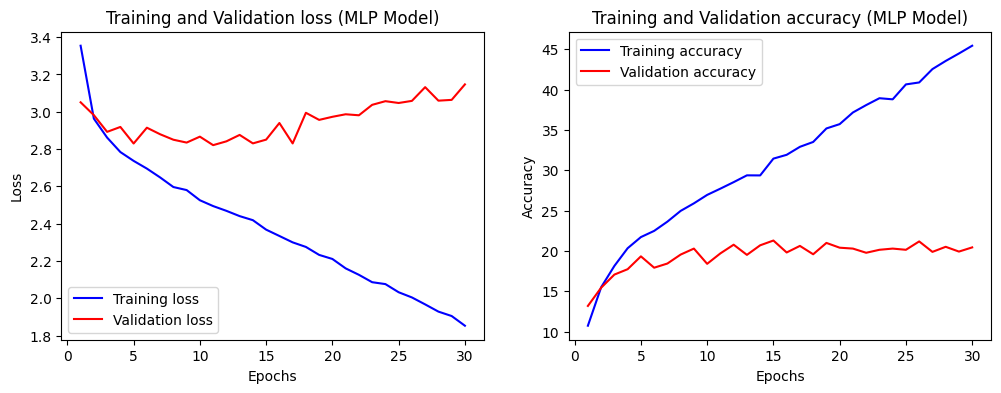

In [80]:
# Plot training history for MLP
plot_training_history(mlp_train_history, 'mlp')

In [ ]:
#TO COMPLETE --> Running your CNN model class

In [118]:
# Initialize the model, loss function, and optimizer
cnn_model = SimpleCNN()
loss_function_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

In [56]:
# Train CNN Model
cnn_train_history = train_model(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_cnn,
    loss_function=loss_function_cnn,
    num_epochs=30  # Adjust based on your needs
)

Epoch 1/30 - Train Loss: 3.0019, Train Acc: 15.34%, Val Loss: 2.6073, Val Acc: 26.52%
Epoch 2/30 - Train Loss: 2.4000, Train Acc: 31.24%, Val Loss: 2.3405, Val Acc: 32.70%
Epoch 3/30 - Train Loss: 2.0761, Train Acc: 39.94%, Val Loss: 2.2468, Val Acc: 35.30%
Epoch 4/30 - Train Loss: 1.7803, Train Acc: 48.14%, Val Loss: 2.2148, Val Acc: 37.56%
Epoch 5/30 - Train Loss: 1.4619, Train Acc: 57.20%, Val Loss: 2.2205, Val Acc: 38.67%
Epoch 6/30 - Train Loss: 1.1179, Train Acc: 66.81%, Val Loss: 2.4323, Val Acc: 37.04%
Epoch 7/30 - Train Loss: 0.7374, Train Acc: 78.48%, Val Loss: 2.6094, Val Acc: 37.30%
Epoch 8/30 - Train Loss: 0.4332, Train Acc: 88.06%, Val Loss: 3.0126, Val Acc: 36.74%
Epoch 9/30 - Train Loss: 0.2363, Train Acc: 94.26%, Val Loss: 3.2880, Val Acc: 36.93%
Epoch 10/30 - Train Loss: 0.1386, Train Acc: 97.06%, Val Loss: 3.6872, Val Acc: 36.15%
Epoch 11/30 - Train Loss: 0.0742, Train Acc: 98.69%, Val Loss: 4.0337, Val Acc: 37.26%
Epoch 12/30 - Train Loss: 0.0526, Train Acc: 99.08%,

In [ ]:
# Your graph

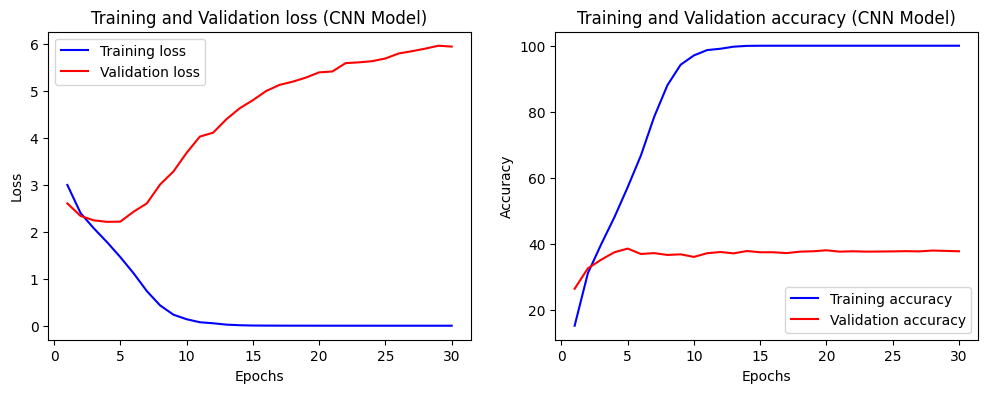

In [79]:
# Plot training history for CNN
plot_training_history(cnn_train_history, 'cnn')

As observed form the plots above, a simple CNN model have considerably better performance in terms of loss and accuracy than a simple MLP model. it is also evident that higehr epoch counts are necessary to achieve consistent performance with new dataset. Due to lack of compute power, epoch upto 30 has been depicted in this section.



### 2.2 Generating confusion matrix and ROC curves (6 marks)
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.
- Display an ROC curve for the two top and two bottom classes with area under the curve

In [ ]:
# Your code here!

In [58]:
def evaluate_model(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.view(-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return np.array(predictions), np.array(true_labels)

In [78]:
def plot_confusion_matrix(cm, class_names):
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    fig, ax = plt.subplots(figsize=(17, 17))
    im = ax.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm_percent.shape[1]),
           yticks=np.arange(cm_percent.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion matrix (%)',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm_percent.max() / 2.
    for i in range(cm_percent.shape[0]):
        for j in range(cm_percent.shape[1]):
            ax.text(j, i, "{:0.1f}%".format(cm_percent[i, j]),
                    ha="center", va="center",
                    color="white" if cm_percent[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [60]:
def plot_roc_curve_for_classes(fpr, tpr, roc_auc, classes):
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange'])
    for i, color in zip(classes, colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for classes - 2 with lowest AUC and 2 with highest AUC')
    plt.legend(loc="lower right")
    plt.show()

In [61]:
def evaluate_model_probability(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds_proba = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs_proba = torch.softmax(outputs, dim=1).cpu().numpy()  # Ensure this is 2D
            all_preds_proba.extend(outputs_proba)  # Extend appends each array to the list
            true_labels.extend(labels.cpu().numpy())
    return np.array(all_preds_proba), np.array(true_labels)  # Convert list to np.array for further processing

In [62]:
# Evaluating model to get predictions
train_preds, train_labels = evaluate_model(cnn_model, train_loader)
val_preds, val_labels = evaluate_model(cnn_model, val_loader)

# Calculating confusion matrices
cm_train = confusion_matrix(train_labels, train_preds)
cm_val = confusion_matrix(val_labels, val_preds)

In [63]:
class_names = val_loader.dataset.dataset.classes

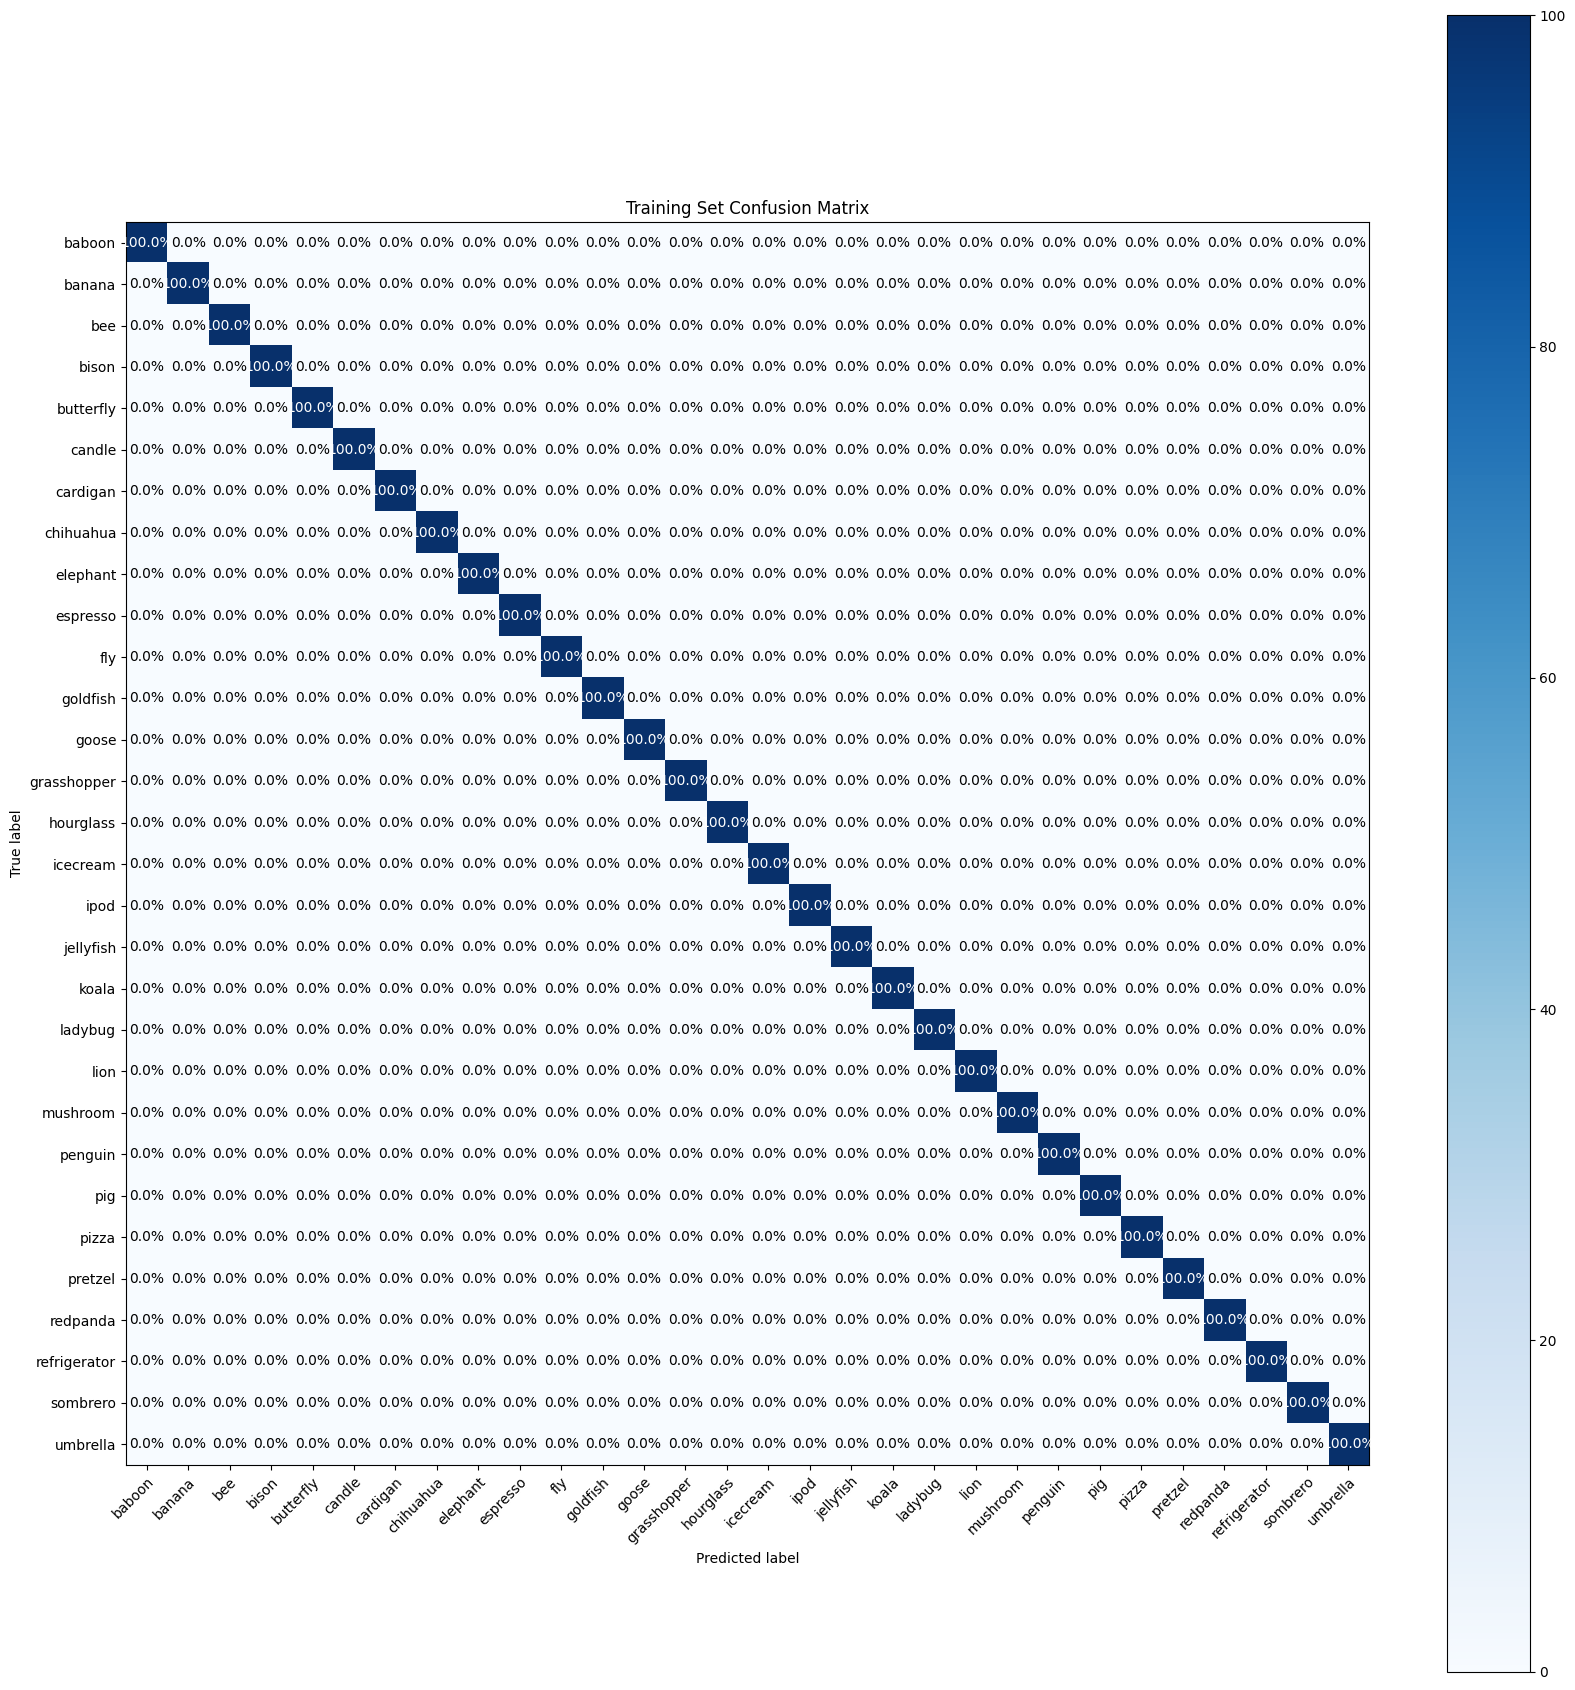

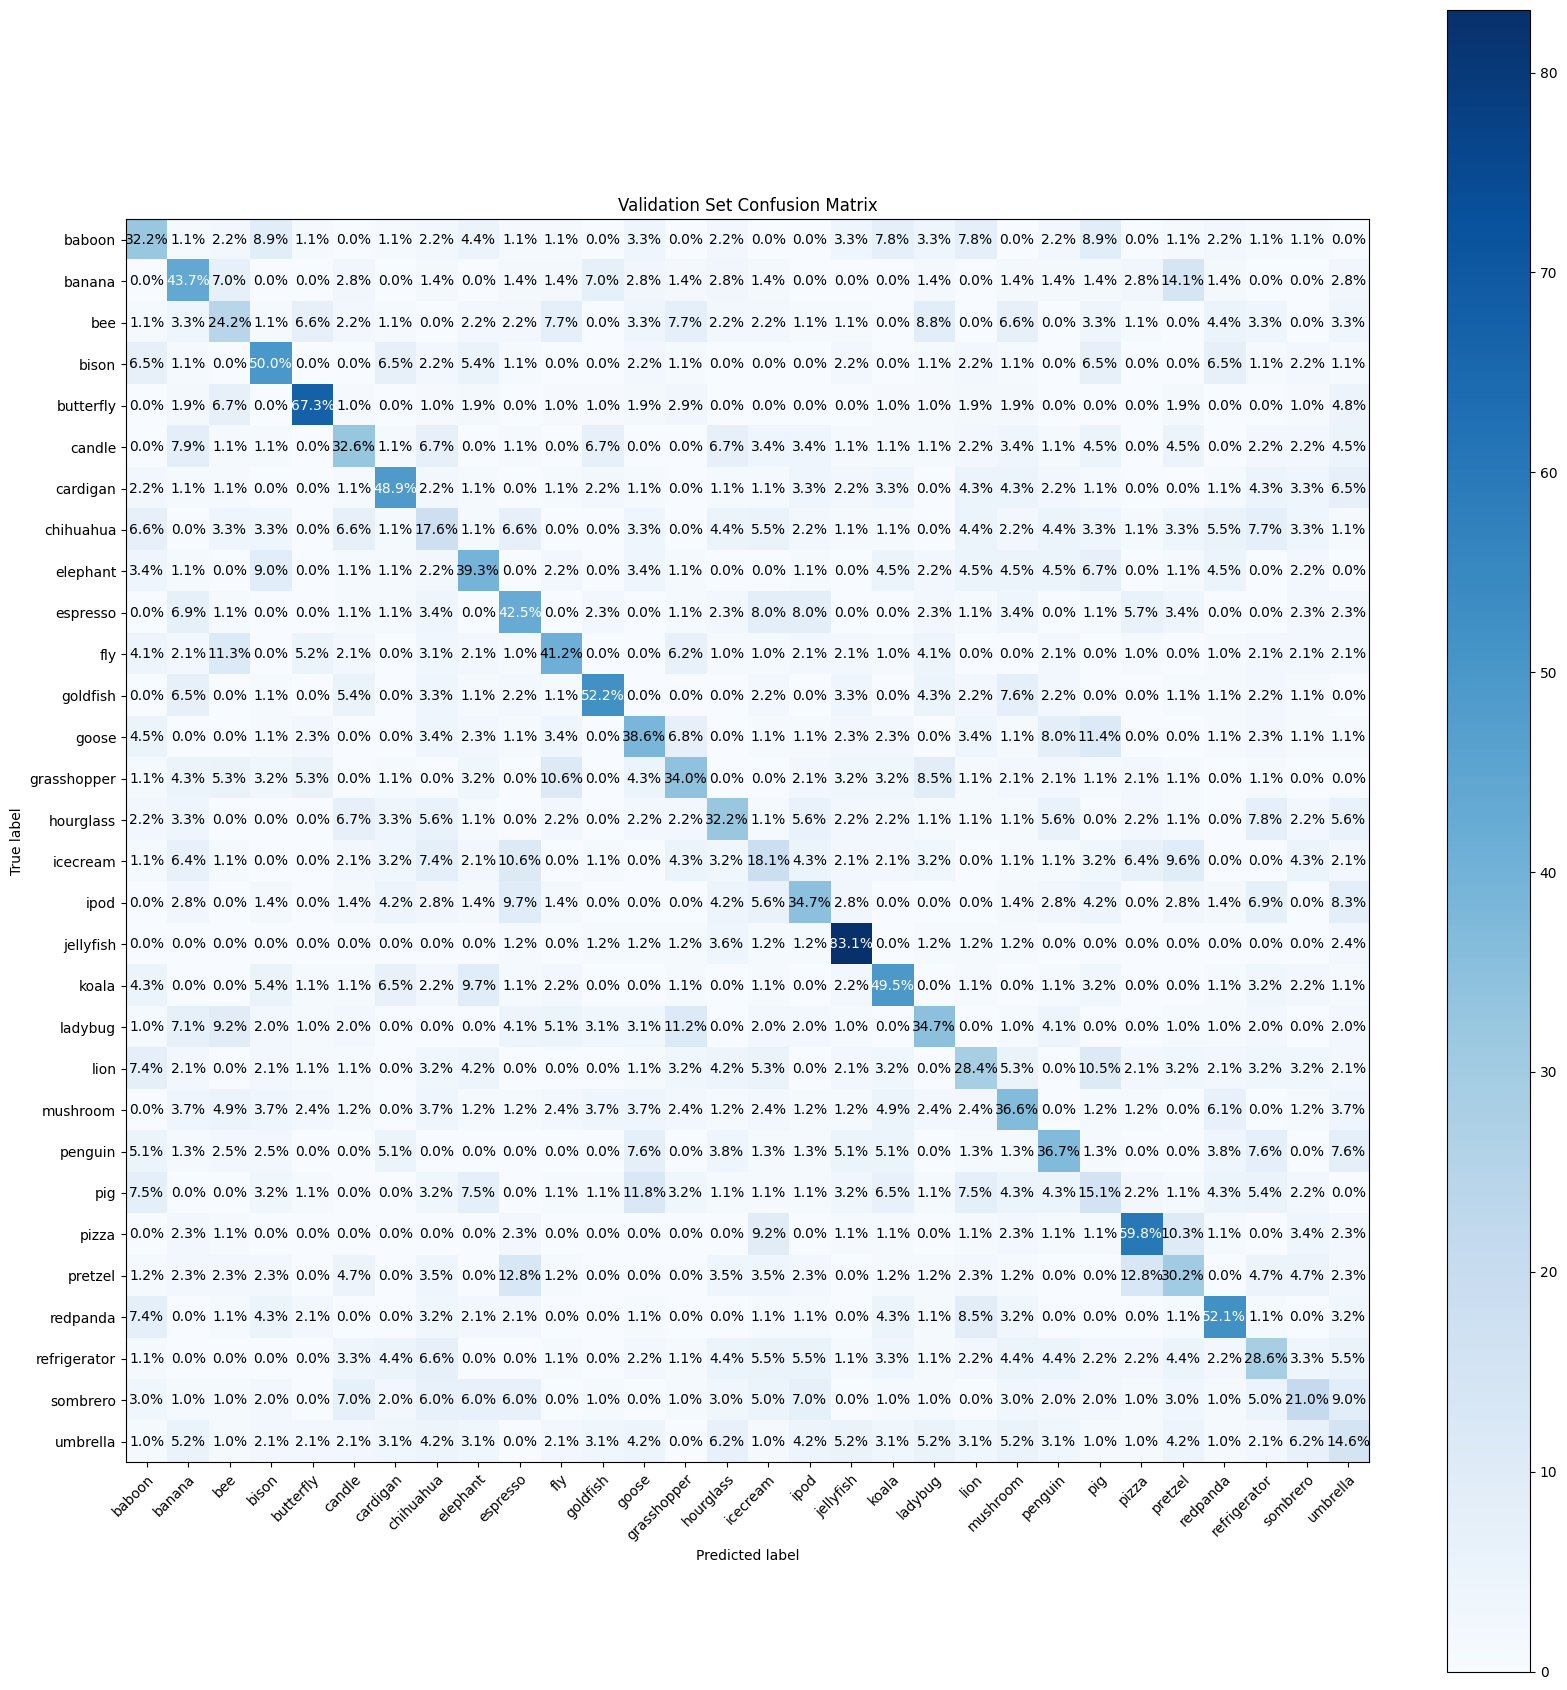

In [81]:
# All of 30 class names stored in `class_names`
plot_confusion_matrix(cm_train, class_names)
plt.title("Training Set Confusion Matrix")
plt.show()

plot_confusion_matrix(cm_val, class_names)
plt.title("Validation Set Confusion Matrix")
plt.show()

In [66]:
# Use the modified evaluate_model function to get probabilities
val_preds_proba, val_labels = evaluate_model_probability(cnn_model, val_loader)

# Compute ROC curve and ROC area for each class
n_classes = len(class_names)  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(val_labels == i, val_preds_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


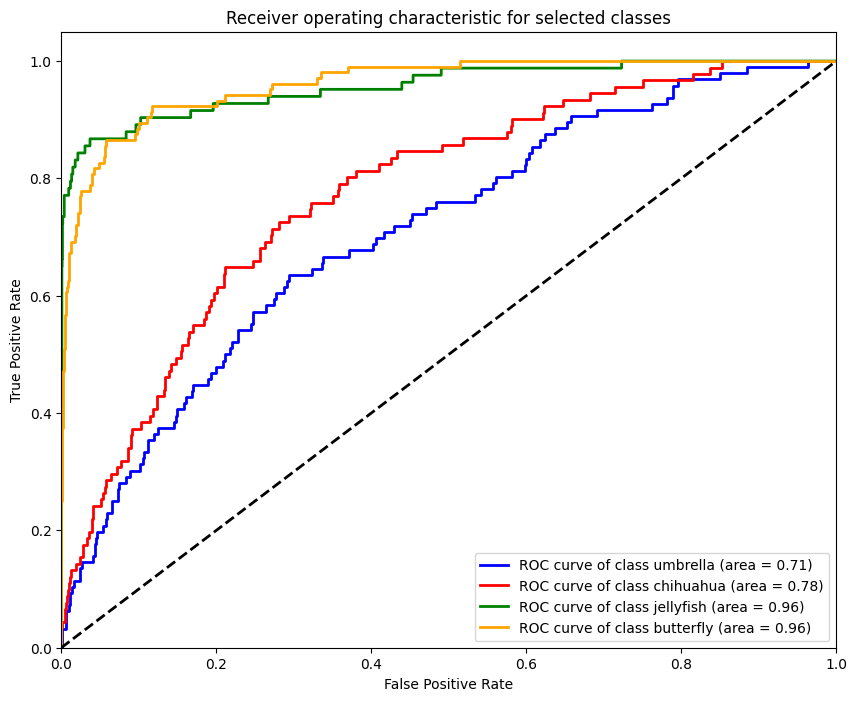

In [67]:
# Here, roc_auc is a dictionary with classes as keys and their AUCs as values
aucs = [(class_id, auc) for class_id, auc in roc_auc.items()]

# Sort by AUC value
aucs_sorted = sorted(aucs, key=lambda x: x[1])

# Select the classes - 2 with lowest AUC and 2 with highest AUC
selected_classes = aucs_sorted[:2] + aucs_sorted[-2:]

# Extract just the class IDs for plotting
selected_class_ids = [class_id for class_id, _ in selected_classes]

# ROC plot for classes - 2 with lowest AUC and 2 with highest AUC
selected_classes = selected_class_ids
plot_roc_curve_for_classes(fpr, tpr, roc_auc, selected_classes)

### Redesign your CNN model (optional)
> This is optional and does not carry any marks. Often to tackle model underfitting we tend to make more complex network design. Depending on your observation, you can improve your model if you wish.

In [ ]:
# Your code here (optional)

Redesigned the CNN architecture by adding multiple convolutional layers.

In [69]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        # Convolutional layer (sees 64x64x3 image tensor)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # Convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Convolutional layer
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        # Adaptive pooling layer
        self.adap_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer
        self.fc1 = nn.Linear(256, 512)
        # Fully connected layey
        self.fc2 = nn.Linear(512, 128)
        # Fully connected layer to get class scores
        self.fc3 = nn.Linear(128, 30)

    def forward(self, x):
        # Convolutional + batch norm + activation + pooling layers
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        # Adaptive pooling and flattening
        x = self.adap_pool(x)
        x = x.view(-1, 256)  # Adjust this depending on the output of your conv layers
        # Fully connected + activation layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


**Note: All questions below here relates to the CNN model only and not an MLP model! You are advised to use your final CNN model only for each of the questions below.**

### 2.3 Strategies for tackling overfitting (18 marks)
Using your (final) CNN model perform the strategies below to avoid overfitting problems. You can resuse the network weights from previous training, often referred to as ``fine tuning``.
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

> Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation (6 marks)

> Implement at least five different data augmentation techniques that should include both photometric and geometric augmentations.

> Provide graphs and comment on what you observe.


In [ ]:
# Your code here!

In [105]:
# Augmentation techniques: three geometric and two photometric
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),    # Geometric: Flips the image horizontally
    transforms.RandomRotation(20),        # Geometric: Rotates the image by up to 20 degrees
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)), # Geometric: Random crops and resizes back to original
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Photometric: Randomly changes brightness, contrast, and saturation
    transforms.RandomGrayscale(p=0.2),    # Photometric: Converts to grayscale with a probability of 0.2
    transforms.ToTensor(),                # Convert PIL image to tensor
])

In [106]:
train_loader_augmented, val_loader_augmented = create_datasets_and_loaders(
    data_directory=dir,
    transformation=augmentation_transforms,
    val_augment=False,
    test_ratio=0.2,
    batch_size=64,
    seed=0
)
print((len(train_loader), len(val_loader)))

(169, 43)


In [107]:
# Initialize the model, loss function, and optimizer
cnn_model_enhanced = EnhancedCNN()
loss_function_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

Epoch 1/20 - Train Loss: 4.9002, Train Acc: 0.35%, Val Loss: 4.8860, Val Acc: 0.15%
Epoch 2/20 - Train Loss: 4.9027, Train Acc: 0.32%, Val Loss: 4.8901, Val Acc: 0.26%
Epoch 3/20 - Train Loss: 4.9026, Train Acc: 0.32%, Val Loss: 4.8909, Val Acc: 0.37%
Epoch 4/20 - Train Loss: 4.9018, Train Acc: 0.37%, Val Loss: 4.8879, Val Acc: 0.30%
Epoch 5/20 - Train Loss: 4.9011, Train Acc: 0.31%, Val Loss: 4.8862, Val Acc: 0.33%
Epoch 6/20 - Train Loss: 4.8990, Train Acc: 0.34%, Val Loss: 4.8892, Val Acc: 0.19%
Epoch 7/20 - Train Loss: 4.9003, Train Acc: 0.32%, Val Loss: 4.8948, Val Acc: 0.30%
Epoch 8/20 - Train Loss: 4.9005, Train Acc: 0.31%, Val Loss: 4.8931, Val Acc: 0.11%
Epoch 9/20 - Train Loss: 4.9015, Train Acc: 0.23%, Val Loss: 4.8909, Val Acc: 0.30%
Epoch 10/20 - Train Loss: 4.9009, Train Acc: 0.41%, Val Loss: 4.8891, Val Acc: 0.19%
Epoch 11/20 - Train Loss: 4.9006, Train Acc: 0.34%, Val Loss: 4.8922, Val Acc: 0.19%
Epoch 12/20 - Train Loss: 4.9026, Train Acc: 0.39%, Val Loss: 4.8879, Val 

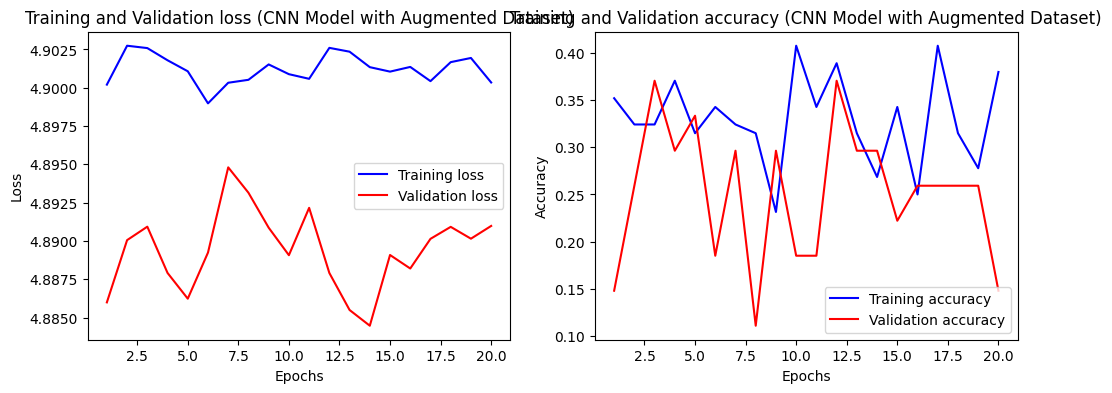

In [112]:
# Continue training with the augmented data loader
cnn_enhanced_train_history_augmented = train_model(
    model=cnn_model_enhanced,
    train_loader=train_loader_augmented,
    val_loader=val_loader_augmented,
    optimizer=optimizer_cnn,
    loss_function=nn.CrossEntropyLoss(),
    num_epochs=20 # You might adjust this based on how your model performs
)

# Plot the training history to observe the effects of augmentation
plot_training_history(cnn_enhanced_train_history_augmented, 'cnn_aug')

After data augmentation and model complexity enhancement, the performance of the complex CNN model has nosedived as observed form the above loss and accuracy plot. Hence, we will be using simple CNN and as our final CNN model. Anticipating better and consistent score post dropout implemetation in the model.

#### 2.3.2 Dropout (6 marks)

> Implement dropout in your model

> Provide graphs and comment on your choice of proportion used.

In [114]:
# Your code here!

In [126]:
class CNNDropout(nn.Module):
    def __init__(self):
        super(CNNDropout, self).__init__()  # Corrected the superclass name
        # Convolutional layer (sees 64x64x3 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Convolutional layer (sees 32x32x16 tensor after pooling)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        # Fully connected layer (sees 16x16x32 tensor after pooling)
        self.fc1 = nn.Linear(32 * 16 * 16, 512)
        # Dropout layer with p=0.5
        self.dropout = nn.Dropout(p=0.2)
        # Fully connected layer to get class scores
        self.fc2 = nn.Linear(512, 30)  # Assuming 30 output classes

    def forward(self, x):
        # Add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten image input
        x = x.view(-1, 32 * 16 * 16)
        # Add dropout layer after the first fully connected layer
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [127]:
# Initialize the model, loss function, and optimizer
cnn_model_dropout = CNNDropout()
loss_function_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

Epoch 1/30 - Train Loss: 3.4026, Train Acc: 3.42%, Val Loss: 3.4034, Val Acc: 3.19%
Epoch 2/30 - Train Loss: 3.4024, Train Acc: 3.51%, Val Loss: 3.4033, Val Acc: 3.22%
Epoch 3/30 - Train Loss: 3.4024, Train Acc: 3.61%, Val Loss: 3.4032, Val Acc: 3.30%
Epoch 4/30 - Train Loss: 3.4023, Train Acc: 3.44%, Val Loss: 3.4035, Val Acc: 3.30%
Epoch 5/30 - Train Loss: 3.4023, Train Acc: 3.56%, Val Loss: 3.4033, Val Acc: 3.19%
Epoch 6/30 - Train Loss: 3.4021, Train Acc: 3.61%, Val Loss: 3.4034, Val Acc: 3.30%
Epoch 7/30 - Train Loss: 3.4024, Train Acc: 3.50%, Val Loss: 3.4032, Val Acc: 3.15%
Epoch 8/30 - Train Loss: 3.4023, Train Acc: 3.51%, Val Loss: 3.4035, Val Acc: 3.22%
Epoch 9/30 - Train Loss: 3.4024, Train Acc: 3.56%, Val Loss: 3.4033, Val Acc: 3.26%
Epoch 10/30 - Train Loss: 3.4024, Train Acc: 3.45%, Val Loss: 3.4034, Val Acc: 3.22%
Epoch 11/30 - Train Loss: 3.4023, Train Acc: 3.54%, Val Loss: 3.4034, Val Acc: 3.26%
Epoch 12/30 - Train Loss: 3.4024, Train Acc: 3.66%, Val Loss: 3.4031, Val 

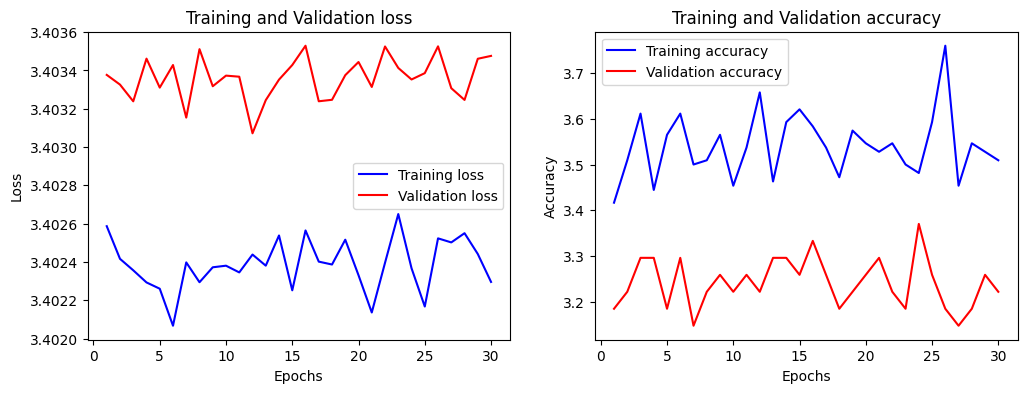

In [128]:
# Continue training with the augmented data loader
cnn_train_history_augmented_dropout = train_model(
    model=cnn_model_dropout,
    train_loader=train_loader_augmented,
    val_loader=val_loader_augmented, # Validation loader doesn't need augmentation
    optimizer=optimizer_cnn,
    loss_function=nn.CrossEntropyLoss(),
    num_epochs=30

# Remember to plot the training history to observe the effects of augmentation
plot_training_history(cnn_train_history_augmented_dropout, 'cnn_aug_do')

We observe another drastic degradation in model performance after implementing dropout layer with p values as 0.2, 0.5 and 0.8 but all failed to replicate 'SimpleCNN()' model performance without dropouts. Hence, I have shown the result of dropout implementation but will not be implementing it in the final model for prediction of test_set

#### 2.3.3 Hyperparameter tuning (6 marks)

> Use learning rates [0.1, 0.001, 0.0001].

> Provide graphs each for loss and accuracy at three different learning rates in a single graph.

In [ ]:
# Your code here!

In [ ]:
# Initialize the model, loss function, and optimizer
cnn_model = SimpleCNN()
loss_function_cnn = nn.CrossEntropyLoss()

In [136]:
# Initializing optimizer and adjusting learning rates
optimizer_cnn_lr_low = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)

In [137]:
# Continue training with the unaugmented data loader
cnn_train_history_augmented_dropout_lr_low = train_model(
    model=cnn_model,
    save_model=False,
    train_loader=train_loader,
    val_loader=val_loader, # using unaugmented data for better performance
    optimizer=optimizer_cnn_lr_low,
    loss_function=nn.CrossEntropyLoss(),
    num_epochs=20 # You might adjust this based on how your model performs
)

Epoch 1/20 - Train Loss: 2.0670, Train Acc: 40.56%, Val Loss: 2.2459, Val Acc: 35.11%
Epoch 2/20 - Train Loss: 1.9729, Train Acc: 43.08%, Val Loss: 2.2100, Val Acc: 36.37%
Epoch 3/20 - Train Loss: 1.9180, Train Acc: 44.74%, Val Loss: 2.1966, Val Acc: 37.15%
Epoch 4/20 - Train Loss: 1.8668, Train Acc: 45.99%, Val Loss: 2.1714, Val Acc: 37.33%
Epoch 5/20 - Train Loss: 1.8190, Train Acc: 47.23%, Val Loss: 2.1609, Val Acc: 37.52%
Epoch 6/20 - Train Loss: 1.7735, Train Acc: 49.05%, Val Loss: 2.1352, Val Acc: 38.37%
Epoch 7/20 - Train Loss: 1.7277, Train Acc: 49.96%, Val Loss: 2.1398, Val Acc: 39.37%
Epoch 8/20 - Train Loss: 1.6812, Train Acc: 51.67%, Val Loss: 2.1302, Val Acc: 39.93%
Epoch 9/20 - Train Loss: 1.6330, Train Acc: 52.69%, Val Loss: 2.1075, Val Acc: 39.96%
Epoch 10/20 - Train Loss: 1.5859, Train Acc: 54.15%, Val Loss: 2.1311, Val Acc: 39.74%
Epoch 11/20 - Train Loss: 1.5378, Train Acc: 56.02%, Val Loss: 2.1133, Val Acc: 40.30%
Epoch 12/20 - Train Loss: 1.4909, Train Acc: 57.10%,

In [138]:
# Initializing optimizer and adjusting learning rates
optimizer_cnn_lr_med = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

In [139]:
# Continue training with the unaugmented data loader
cnn_train_history_augmented_dropout_lr_med = train_model(
    model=cnn_model,
    save_model=True,
    train_loader=train_loader_augmented,
    val_loader=val_loader_augmented, # using unaugmented data for better performance
    optimizer=optimizer_cnn_lr_med,
    loss_function=nn.CrossEntropyLoss(),
    num_epochs=20
)

Epoch 1/20 - Train Loss: 2.2769, Train Acc: 35.02%, Val Loss: 2.4352, Val Acc: 32.56%
Epoch 2/20 - Train Loss: 2.1888, Train Acc: 37.25%, Val Loss: 2.3283, Val Acc: 33.74%
Epoch 3/20 - Train Loss: 2.1135, Train Acc: 39.33%, Val Loss: 2.3566, Val Acc: 33.56%
Epoch 4/20 - Train Loss: 2.0610, Train Acc: 40.79%, Val Loss: 2.3667, Val Acc: 32.85%
Epoch 5/20 - Train Loss: 2.0150, Train Acc: 41.87%, Val Loss: 2.3051, Val Acc: 35.56%
Epoch 6/20 - Train Loss: 1.9733, Train Acc: 43.44%, Val Loss: 2.2804, Val Acc: 37.41%
Epoch 7/20 - Train Loss: 1.9380, Train Acc: 43.96%, Val Loss: 2.2299, Val Acc: 37.89%
Epoch 8/20 - Train Loss: 1.9011, Train Acc: 45.27%, Val Loss: 2.2708, Val Acc: 37.59%
Epoch 9/20 - Train Loss: 1.8516, Train Acc: 46.29%, Val Loss: 2.3033, Val Acc: 35.74%
Epoch 10/20 - Train Loss: 1.8313, Train Acc: 46.59%, Val Loss: 2.1798, Val Acc: 40.15%
Epoch 11/20 - Train Loss: 1.7862, Train Acc: 47.55%, Val Loss: 2.2381, Val Acc: 37.22%
Epoch 12/20 - Train Loss: 1.7505, Train Acc: 48.49%,

In [140]:
# Initializing optimizer and adjusting learning rates
optimizer_cnn_lr_high = torch.optim.Adam(cnn_model.parameters(), lr=0.1)

In [141]:
# Continue training with the unaugmented data loader
cnn_train_history_augmented_dropout_lr_high = train_model(
    model=cnn_model,
    save_model=False,
    train_loader=train_loader_augmented,
    val_loader=val_loader_augmented, # using unaugmented data for better performance
    optimizer=optimizer_cnn_lr_high,
    loss_function=nn.CrossEntropyLoss(),
    num_epochs=20
)

Epoch 1/20 - Train Loss: 63.7307, Train Acc: 3.62%, Val Loss: 3.4237, Val Acc: 2.93%
Epoch 2/20 - Train Loss: 3.4151, Train Acc: 3.31%, Val Loss: 3.4103, Val Acc: 3.85%
Epoch 3/20 - Train Loss: 3.4184, Train Acc: 3.35%, Val Loss: 3.4202, Val Acc: 3.63%
Epoch 4/20 - Train Loss: 3.4148, Train Acc: 3.39%, Val Loss: 3.4163, Val Acc: 3.41%
Epoch 5/20 - Train Loss: 3.4165, Train Acc: 3.46%, Val Loss: 3.4139, Val Acc: 3.48%
Epoch 6/20 - Train Loss: 3.4166, Train Acc: 3.23%, Val Loss: 3.4181, Val Acc: 3.07%
Epoch 7/20 - Train Loss: 3.4167, Train Acc: 3.32%, Val Loss: 3.4193, Val Acc: 3.85%
Epoch 8/20 - Train Loss: 3.4187, Train Acc: 3.32%, Val Loss: 3.4143, Val Acc: 3.22%
Epoch 9/20 - Train Loss: 3.4189, Train Acc: 3.19%, Val Loss: 3.4118, Val Acc: 2.93%
Epoch 10/20 - Train Loss: 3.4169, Train Acc: 2.94%, Val Loss: 3.4201, Val Acc: 3.33%
Epoch 11/20 - Train Loss: 3.4163, Train Acc: 3.35%, Val Loss: 3.4207, Val Acc: 3.63%
Epoch 12/20 - Train Loss: 3.4207, Train Acc: 2.90%, Val Loss: 3.4115, Val

In [ ]:
# Your graph

In [142]:
# Loss and Accuracy plot of training and validation sets when learning rate = 0.0001, 0.001, 0.01
def plot_for_learn_rate():
    epochs = range(1, len(cnn_train_history_augmented_dropout_lr_low['train_loss']) + 1)
    plt.figure(figsize=(10, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, cnn_train_history_augmented_dropout_lr_low['train_loss'], color='b', label='Training loss (LR = 0.0001)')
    plt.plot(epochs, cnn_train_history_augmented_dropout_lr_low['val_loss'], color='g', label='Validation loss (LR = 0.0001)')
    plt.plot(epochs, cnn_train_history_augmented_dropout_lr_med['train_loss'], color='r', label='Training loss (LR = 0.001)')
    plt.plot(epochs, cnn_train_history_augmented_dropout_lr_med['val_loss'], color='c', label='Validation loss (LR = 0.001)')
    plt.plot(epochs, cnn_train_history_augmented_dropout_lr_high['train_loss'], color='m', label='Training loss (LR = 0.1)')
    plt.plot(epochs, cnn_train_history_augmented_dropout_lr_high['val_loss'], color='y', label='Validation loss (LR = 0.1)')
    plt.title('Loss plot for LR = 0.0001, 0.001, 0.01')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, cnn_train_history_augmented_dropout_lr_low['train_acc'], color='b', label='Training accuracy (LR = 0.0001)')
    plt.plot(epochs, cnn_train_history_augmented_dropout_lr_low['val_acc'], color='g', label='Validation accuracy (LR = 0.0001)')
    plt.plot(epochs, cnn_train_history_augmented_dropout_lr_med['train_acc'], color='r', label='Training accuracy (LR = 0.001)')
    plt.plot(epochs, cnn_train_history_augmented_dropout_lr_med['val_acc'], color='c', label='Validation accuracy (LR = 0.001)')
    plt.plot(epochs, cnn_train_history_augmented_dropout_lr_high['train_acc'], color='m', label='Training accuracy (LR = 0.1)')
    plt.plot(epochs, cnn_train_history_augmented_dropout_lr_high['val_acc'], color='y', label='Validation accuracy (LR = 0.1)')
    plt.title('Accuracy plot for LR = 0.0001, 0.001, 0.01')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

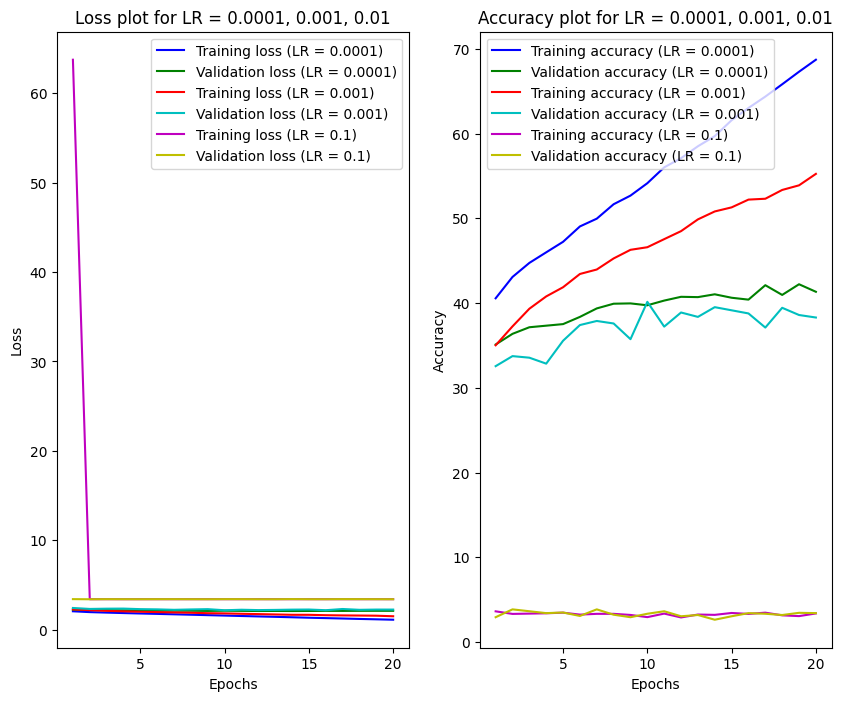

In [143]:
plot_for_learn_rate()

### 3 Model testing [10 marks]
Online evaluation of your model performance on the test set.

> Prepare the dataloader for the testset.

> Write evaluation code for writing predictions.

> Upload it to Kaggle submission page (6 marks)


#### 3.1 Test class and predictions (4 marks)

> Build a test class, prepare a test dataloader and generate predictions

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set).

In [ ]:
# Your code here!

In [151]:
class SingleFolderDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure image is RGB
        if self.transform:
            image = self.transform(image)
        return image, image_path

In [146]:
# Load your trained model
model = SimpleCNN().to(device)
model.load_state_dict(torch.load('/content/CNN_augmented_LR_0.001.pth', map_location=device).state_dict())
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=30, bias=True)
)

In [162]:
import torchvision.datasets as datasets

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    # Include any other transforms your model was trained with
])

test_dataset = SingleFolderDataset('/content/drive/MyDrive/DL_Data/comp5625m-artificial-intelligence-2024/test_set', transform=test_transforms)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

len(test_loader)

In [193]:
def generate_predictions(model, data_loader, device):
    model.to(device)
    model.eval()

    # Predict and store results
    predictions = []
    image_paths = []
    for inputs, paths in data_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        image_paths.extend(paths)

    # Save to CSV
    df = pd.DataFrame({'Path': image_paths, 'Category': predictions})
    # Extract image names
    df['Id'] = df['Path'].apply(lambda x: x.split('/')[-1])
    df=df[['Id', 'Category']]
    df.to_csv('predictions.csv', index=False)
    print("Predictions have been saved to predictions.csv")

#### 3.2 Prepare your submission and upload to Kaggle  (6 marks)

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, e.g., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers. [To submit please click here.](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07)

> You may submit multiple times. We will use your personal top entry for allocating marks for this [6 marks].


In [ ]:
# Your code here!

In [194]:
# Call the function
generate_predictions(model, test_loader, device)

Predictions have been saved to predictions.csv



### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset  [16 marks]

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one given task and then tunes or tweaks the model to make it perform a second similar task. You can perform fine-tuning in following fashion:

- Train an entire model: Start training model from scratch (large dataset, more computation)

- Train some layers, freeze others: Lower layer features are general (problem independent) while higher layer features are specific (problem dependent – freeze)

- Freeze convolution base and train only last FC layers (small dataset and lower computation)

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10`` [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here is only 10*


In [ ]:
# Your code here!

In [195]:
datadir = '/content/drive/MyDrive/DL_Data/CIFAR10_Dataset'

In [196]:
def load_split_train_test(datadir, valid_size = .2):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = torchvision.datasets.CIFAR10(datadir, download=True, train=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(datadir, download=True, train=False, transform=transform)

    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)

    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sampler, batch_size=64)
    validationloader = torch.utils.data.DataLoader(trainset, sampler=valid_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

    return trainloader, validationloader, testloader

In [197]:
def validate_model(model, validationloader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validationloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Validation Accuracy: {100 * correct / total}%, Validation Loss: {val_loss / len(validationloader)}')

In [198]:
def train_model(model, trainloader, validationloader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")

        validate_model(model, validationloader, criterion)

In [199]:
trainloader, validationloader, testloader = load_split_train_test(datadir, valid_size = .2)

100%|██████████| 170498071/170498071 [00:03<00:00, 49159973.24it/s]


Extracting /content/drive/MyDrive/DL_Data/CIFAR10_Dataset/cifar-10-python.tar.gz to /content/drive/MyDrive/DL_Data/CIFAR10_Dataset
Files already downloaded and verified


> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [ ]:
# Your code here!

#### 4.1 Apply transfer learning with pretrained model weights (6 marks)


> Configuration 1: No frozen layers

In [200]:
def initialize_model(num_classes=10):
    net = models.alexnet(pretrained=True)
    # No frozen layer
    for param in net.parameters():
        param.requires_grad = False
    num_ftrs = net.classifier[6].in_features
    net.classifier[6] = nn.Linear(num_ftrs, num_classes)
    return net

In [ ]:
# Your model changes here - also print trainable parameters

In [205]:
# Initialize and train model on pretrained weights
model = initialize_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)
train_model(model, trainloader, validationloader, criterion, optimizer, num_epochs=30)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

#### 4.2 Fine-tuning model with frozen layers (6 marks)

> Configuration 2: Frozen base convolution blocks

In [ ]:
# Your changes here - also print trainable parameters

In [207]:
def initialize_model_confz(num_classes=10, pretrained=True):
    # Load a pretrained AlexNet model
    net = models.alexnet(pretrained=pretrained)

    # Freeze the convolutional base
    for param in net.features.parameters():
        param.requires_grad = False

    num_ftrs = net.classifier[6].in_features
    net.classifier[6] = nn.Linear(num_ftrs, num_classes)

    return net

In [209]:
# Initialize and train model on pretrained weights
model = initialize_model_confz()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)
train_model(model, trainloader, validationloader, criterion, optimizer, num_epochs=30)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

#### 4.3 Compare above configurations and comment on performances. (4 marks)

In [ ]:
# Your graphs here and please provide comment in markdown in another cell

### Part II: Image Captioning using RNN [30 marks]



### Motivation

Through this part of assessment you will:

> 1. Understand the principles of text pre-processing and vocabulary building (provided).
> 2. Gain experience working with an image to text model.
> 3. Use and compare text similarity metrics for evaluating an image to text model, and understand evaluation challenges.

#### Dataset
This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images, of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each of which has five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H).

``Info only:`` To understand more about the COCO dataset you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)" but our image subset consists of fewer images compared to orginial COCO dataset. So, no need to download anything from here!

> 2. **Image meta data**: as our set is a subset of full COCO dataset, we have created a CSV file containing relevant meta data for our particular subset of images. You can download it also from Drive, "coco_subset_meta.csv" at the same link as 1.

#### Submission

You can either submit the same file or make a two separate .ipython notebook files zipped in the submission (please name as ``yourstudentusername_partI.ipynb`` and ``yourstudentusername_partII.ipynb``).

**Final note:**

> **Please include in this notebook everything that you would like to be marked, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects.

You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you fine-tuned to COCO dataset.

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer to speed up training*. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use an **RNNs** in this assessment).

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) -->

<div>
<center><img src="comp5625M_figure.jpg" width="1000"/></center>
</div>


### Instructions for creating vocabulary

A helper function file ``helperDL.py`` is provided that includes all the functions that will do the following for you. You can easily import these functions in the exercise, most are already done for you!  

> 1. Extracting image features (a trained checkpoint is provided ``resnet50_caption.pt`` for you to download and use it for training your RNN)
> 2. Text preparation of training and validation data is provided

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from collections import Counter

import os
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

**Please refer to the submission section at the top of this notebook to prepare your submission.**


In [ ]:
# Load the feature map provided to you
features_map = torch.load('coco_features_'+(device.type)+'.pt', map_location=device)

#### 5 Train DecoderRNN [20 marks]

> 5.1 Design a RNN-based decoder (10 marks)

> 5.2 Train your model with precomputed features (10 Marks)

##### 5.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [ ]:
import json
import pandas as pd

with open('coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)

df = pd.DataFrame.from_dict(data["annotations"])
df.head()

In [ ]:
coco_subset = pd.read_csv("coco_subset_meta.csv")
new_data = pd.DataFrame( data['annotations'])
new_coco = coco_subset.rename(columns={'id':'image_id'})
new_coco.drop_duplicates('file_name',keep='first',inplace=True)

new_subset = new_data.sort_values(['image_id'], ascending=True)
# Get all the reference captions
new_file = pd.merge(new_coco,new_subset,how = 'inner', on = 'image_id')
new_file = new_file[['image_id','id','caption','file_name']]
new_file = new_file.sort_values(['image_id'], ascending = True)
new_file.head(10)

In [ ]:
# getting the clearn clean - e.g., converting all uppercases to lowercases
new_file["clean_caption"] = ""
from helperDL import gen_clean_captions_df
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

In [ ]:
##### Spilt your training, validation and test dataset with indexes to each set
from helperDL import split_ids
train_id, valid_id, test_id = split_ids(new_file['image_id'].unique())
print("training:{}, validation:{}, test:{}".format(len(train_id), len(valid_id), len(test_id)))

In [ ]:
train_set = new_file.loc[new_file['image_id'].isin(train_id)]
valid_set = new_file.loc[new_file['image_id'].isin(valid_id)]
test_set = new_file.loc[new_file['image_id'].isin(test_id)]

In [ ]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
### build vocabulariy for each set - train, val and test
# you will be using to create dataloaders
from helperDL import build_vocab

# create a vocab instance
vocab = Vocabulary()
vocab_train = build_vocab(train_id, new_file, vocab)
vocab_valid = build_vocab(valid_id, new_file, vocab)
vocab_test = build_vocab(test_id, new_file, vocab)

vocab = vocab_train # using only training samples as vocabulary as instructed above
print("Total vocabulary size: {}".format(len(vocab_train)))


In [ ]:
# They can also join the train and valid captions but they will need to run vocabulary after concatenation
import numpy as np
vocab = build_vocab(np.concatenate((train_id, valid_id), axis=0), new_file, vocab) #---> overrighting
len(vocab)

Instantiate a ```DataLoader``` for your image feature and caption dataset. ``helperDL.py`` file includes all the required functions

We need to overwrite the default PyTorch collate_fn() because our
ground truth captions are sequential data of varying lengths. The default
collate_fn() does not support merging the captions with padding.

You can read more about it here:
https://pytorch.org/docs/stable/data.html#dataloader-collate-fn.


In [ ]:
from helperDL import EncoderCNN
model = EncoderCNN()
print(model)

In [ ]:
''' Load the saved image feature maps and trained model ("provided to you") '''

# ---> your entry here (make sure that the path is correct)
features_path = "/content/drive/MyDrive/DL_Data/coco_features.pt"  # Update this path
features = torch.load(features_path)

# also load the model ckpt and udate the model state dict of the base model
# Define model architecture
model = models.resnet50(pretrained=False)  # ResNet50

# Load the checkpoint
checkpoint_path = "path_to_your_checkpoint/your_checkpoint_file.pt"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))  # or 'cuda'

# Update the model's state dictionary
model.load_state_dict(checkpoint['model_state_dict'])
# ---> your entry here (make sure that the path is correct)
checkpoint = torch.load("ckpt file here")
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
##### Preparing the train, val and test dataloaders
from helperDL import COCO_Features
from helperDL import caption_collate_fn


# Create a dataloader for train
dataset_train = COCO_Features(
    df=train_set,
    vocab=vocab,
    features=features_map,
)

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

# Create a dataloader for valid
dataset_valid = COCO_Features(
    df=valid_set,
    vocab=vocab,
    features=features_map,
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

In [ ]:
# say this is as below
# --> Please change these numbers as required.
# --> Please comment on changes that you do.
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1
LR = 0.001
NUM_EPOCHS = 5
LOG_STEP = 10
MAX_SEQ_LEN = 37

#### 5.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        super(DecoderRNN, self).__init__()

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.resize = nn.Linear(2048, hidden_size)  # Assuming the input feature size is 2048
        self.bn = nn.BatchNorm1d(hidden_size, momentum=0.01)
        self.rnn = nn.RNN(embed_size + hidden_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length

    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        features = self.resize(features)
        features = self.bn(features)

        # Combine the embeddings and the image features
        embeddings = torch.cat((features.unsqueeze(1).expand(-1, embeddings.size(1), -1), embeddings), 2)

        # pack_padded_sequence so that padded items in the sequence won't be shown to the RNN
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)

        # Forward pass through RNN
        hiddens, _ = self.rnn(packed)

        # Decode the hidden state of the last time step
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):
        sampled_ids = []
        inputs = self.bn(self.resize(features)).unsqueeze(1)

        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)

        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [ ]:
# instantiate decoder
decoder = DecoderRNN(len(vocab), embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)

##### 5.2 Train your model with precomputed features (10 marks)

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [ ]:

# loss and optimizer here
# your code here --->

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.001)


# train the models
total_step = len(train_loader)
total_step_v = len(valid_loader)
stats = np.zeros((NUM_EPOCHS,2))
print(stats.shape)
total_loss = 0
for epoch in range(NUM_EPOCHS):
    for i, (features_, captions_, lengths_) in enumerate(train_loader):
        # your code here --->
        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = decoder(features_, captions_, lengths_)

        # Since outputs are packed sequences, unpack them for comparison
        targets = pack_padded_sequence(captions_, lengths_, batch_first=True)[0]

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # print stats
        if i % LOG_STEP == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i}/{total_step}], Loss: {loss.item():.4f}")

    stats[epoch,0] = round(total_loss/total_step,3)
    total_loss = 0
    decoder.eval()
    with torch.no_grad():
        for i, (features_, captions_, lengths_) in enumerate(valid_loader):
            # your code here --->
            outputs = decoder(features_, captions_, lengths_)
            targets = pack_padded_sequence(captions_, lengths_, batch_first=True)[0]
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    stats[epoch,1] = round(total_loss/total_step_v,3)
    total_loss = 0
    # print stats
    print("="*30)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train_Loss: {stats[epoch,0]}, Valid_Loss: {stats[epoch,1]}")
    print("="*30)
    decoder.train()

In [ ]:
fig = plt.figure()

plt.plot(stats[:,0], 'r', label = 'training', )
plt.plot(stats[:,1], 'g', label = 'validation' )
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f"COCO dataset- train vocab only #vocab={len(vocab)} - 5 epochs")
fig.savefig("coco_train_vocab_only.png")
plt.show()

In [ ]:
# save model after training
decoder_ckpt = torch.save(decoder, "coco_subset_assessment_decoder.ckpt")

### 6 Test prediction and evaluation [10 marks]

#### 6.1 Generate predictions on test data (4 marks)

Display 4 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

dataset_test = COCOImagesDataset(
    df=test_set,
    transform=data_transform,
)
test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False,
    num_workers=0)

In [ ]:
model.eval()
decoder.eval() # generate caption, eval mode to not influence batchnormncoder.eval()

In [ ]:
# getting functions from helperDL.py
from helperDL import timshow
from helperDL import decode_caption

In [ ]:
IMAGES_TO_SHOW = 4
idx = 0
with torch.no_grad():
    for i, (image,filename) in enumerate(test_loader):

        # your code here --->

        # Generate a caption for the current image
        generated_caption = generate_caption(image)

        # Obtain reference captions for the current image
        # You need to have a way to map 'filename' to its reference captions.
        # This could be a dictionary you've constructed during data preparation.
        reference_captions = reference_captions_dict[filename]

        # Display the image
        plt.figure(figsize=(10, 4))
        plt.imshow(image[0].cpu().numpy().transpose(1, 2, 0))  # Adjust this line if necessary
        plt.axis('off')
        plt.show()

        # Print the generated and reference captions
        print(f"GENERATED: \n{generated_caption}\n")
        print("REFERENCES:")

        print("===================================\n")


        timshow(image[0].cpu())
        idx +=1
        if idx == IMAGES_TO_SHOW:
            break

#### 6.2 Caption evaluation using cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions:

* Find the embedding vector of each word in the caption
* Compute the average vector for each caption
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores

Calculate the cosine similarity using the model's predictions over the whole test set.

Display a histogram of the distribution of scores over the test set.

In [ ]:
from torchtext.vocab import GloVe
from scipy.spatial.distance import cosine

# Load GloVe embeddings
glove = GloVe(name='6B', dim=100)

def caption_to_avg_vector(caption, embeddings):
    """
    Convert a caption to an average vector of its word embeddings.

    Args:
    - caption (str): The caption sentence.
    - embeddings (Vocab): Pre-trained word embeddings.

    Returns:
    - torch.Tensor: The average embedding vector of the caption.
    """
    # Tokenize the caption and filter out words not in embeddings
    tokens = [word for word in caption.lower().split() if word in embeddings.stoi]

    if not tokens:
        return torch.zeros(embeddings.dim)

    # Look up the embeddings for each word and take the mean
    vectors = [embeddings[word] for word in tokens]
    return torch.mean(torch.stack(vectors), dim=0)

def compute_cosine_similarity(vec1, vec2):
    """
    Compute the cosine similarity between two vectors.

    Args:
    - vec1 (torch.Tensor): First vector.
    - vec2 (torch.Tensor): Second vector.

    Returns:
    - float: Cosine similarity score.
    """
    # Convert tensors to NumPy arrays for compatibility with scipy
    vec1_np = vec1.numpy()
    vec2_np = vec2.numpy()
    return 1 - cosine(vec1_np, vec2_np)

# Example usage
generated_caption = "A dog playing with a ball"
reference_captions = ["A dog is playing with a ball", "A playful dog running after the ball", "The dog plays with a ball in the park"]

# Convert captions to average vectors
gen_vec = caption_to_avg_vector(generated_caption, glove)
ref_vecs = [caption_to_avg_vector(caption, glove) for caption in reference_captions]

# Compute cosine similarity between generated caption and each reference caption
scores = [compute_cosine_similarity(gen_vec, vec) for vec in ref_vecs]

# Compute the average cosine similarity score
average_score = np.mean(scores)

print(f"Average cosine similarity score: {average_score}")

# To calculate the cosine similarity over the whole test set, repeat the above steps for each item in the test set and collect the scores.

# Example histogram of scores (dummy data)
# Replace 'scores' with the list of average scores computed over your whole test set
plt.hist(scores, bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.show()

##### Thank you for completing the assessment - if you have any question, please ask on teams channel or attend lab sessions on Tuesdays and Wednesdays.